In [1]:
import torch as th
print(th.__version__) # should be greater or equal to 1.0
import torch.nn as nn

import os

import numpy as np
import pickle
import math
import matplotlib
import matplotlib.pyplot as plt 

import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

pi=math.pi

1.7.1


# Generate Dataset

- 4000 images 32x32 de charge topologique totale nulle
- ~4000 images 32x32 de charge topologique totale non nulle (1000 images 64x64 coupées en 4, la charge topologique doit etre non nulle sur ces crop. Sur certains crop le hasard fait que la charge topologique est toujours nulle : on enleve ces images du lot)

Les 8000 images de spin ont été générées via l'algorithme Metropolis. Elles sont importées depuis un dossier stocké sur mon disque dur.

In [2]:
allXtrain=[]
allYtrain=[]

In [5]:
os.chdir('C:\\Users\\sedra\\IDL\\PROJET METROPOLIS\\spin_first\\spin_first_1')
os.getcwd()

'C:\\Users\\sedra\\IDL\\PROJET METROPOLIS\\spin_first\\spin_first_1'

Les images importées ont le format suivant : 32x32 pixels ; float dans l'intervalle [0,1] avec 0 correspondant à l'angle de spin 0 et 1 à 2pi.

La stratégie adoptée pour retrouver la périodicité consiste à mettre deux images en entrée générées à partir de la première (2 channels : RGB avec B=[0]) : le cosinus et le sinus de la valeur de l'angle du spin (replacé entre 0 et 2pi).

In [6]:
for i in range(1,4001):
    try :
        img = mpimg.imread('spin_{}.png'.format(i)) 
        allXtrain.append([np.cos(2*pi*img),np.sin(2*pi*img)])
        allYtrain.append(1)
    except :
        print('spin_{} a une charge topo nulle malgré le crop'.format(i))

spin_91 a une charge topo nulle malgré le crop
spin_283 a une charge topo nulle malgré le crop
spin_375 a une charge topo nulle malgré le crop
spin_501 a une charge topo nulle malgré le crop
spin_580 a une charge topo nulle malgré le crop
spin_587 a une charge topo nulle malgré le crop
spin_638 a une charge topo nulle malgré le crop
spin_639 a une charge topo nulle malgré le crop
spin_715 a une charge topo nulle malgré le crop
spin_749 a une charge topo nulle malgré le crop
spin_899 a une charge topo nulle malgré le crop
spin_1214 a une charge topo nulle malgré le crop
spin_1343 a une charge topo nulle malgré le crop
spin_1525 a une charge topo nulle malgré le crop
spin_1725 a une charge topo nulle malgré le crop
spin_1903 a une charge topo nulle malgré le crop
spin_2048 a une charge topo nulle malgré le crop
spin_2102 a une charge topo nulle malgré le crop
spin_2172 a une charge topo nulle malgré le crop
spin_2179 a une charge topo nulle malgré le crop
spin_2296 a une charge topo null

In [7]:
allXtrain_array=np.array(allXtrain)

Reshape du dataset : [Nbr of images, Nbr of channels, nbr of pixels X,Y]

In [8]:
allXtrain_f=allXtrain_array.reshape(7963, 2, 32, 32)

Le dataset est ensuite transformé en tenseur : 

In [9]:
Xtrain=th.cat([th.from_numpy(np.array(allXtrain_f[:3500,:,:,:])),th.from_numpy(np.array(allXtrain_f[4500:,:,:,:]))])
Ytrain=th.cat([th.from_numpy(np.array(allYtrain[:3500])),th.from_numpy(np.array(allYtrain[4500:]))])

Xvalid=th.from_numpy(np.array(allXtrain_f[3500:4500,:,:,:]))
Yvalid=th.from_numpy(np.array(allYtrain[3500:4500]))

Ytrain=Ytrain.long()
Yvalid=Yvalid.long()

## CNN

In [10]:
import torch.nn.functional as F

In [73]:
class Conv2d_classifier(nn.Module):   
    def __init__(self):
        super(Conv2d_classifier, self).__init__()
        self.conv1 = nn.Conv2d(2,8,5) # 1-nbr channel=R-G ; 2-nbr sorties ; 3-kernel size
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(8*14*14,20) #conv1-pool-conv2-pool
        self.fc2 = nn.Linear(20,2) #2-classif binaire
        self.dropout = nn.Dropout(0.3) 

    # Defining the forward pass    
    def forward(self, x):
        res = x 
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1,8*14*14) #-1- batch size #flatten it 
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        # softmax ? in the loss
        return x

In [62]:
# How to get fc1 input dimension
conv1 = nn.Conv2d(2,8,3)
pool = nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(4,8,5)

sortie=pool(F.relu(conv1(images)))

print(sortie.shape) #gives the shape of the first linear input

fc1 = nn.Linear(8*5*5,50)
fc2 = nn.Linear(50,50)
fc3 = nn.Linear(50,2)

x=sortie
print(x.shape)
x=x.view(-1,8*5*5)
print(x.shape)
x = F.relu(fc1(x))
print(x.shape)
x = F.relu(fc2(x))
print(x.shape)
x = fc3(x)
print(x.shape)


torch.Size([200, 8, 15, 15])
torch.Size([200, 8, 15, 15])
torch.Size([1800, 200])
torch.Size([1800, 50])
torch.Size([1800, 50])
torch.Size([1800, 2])


## Online training

In [74]:
classif = Conv2d_classifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(classif.parameters(), lr=0.001)

6963 1000
200 34
---------- Best : 73.500  at epoch  34  /  35


(0.0, 74.58)

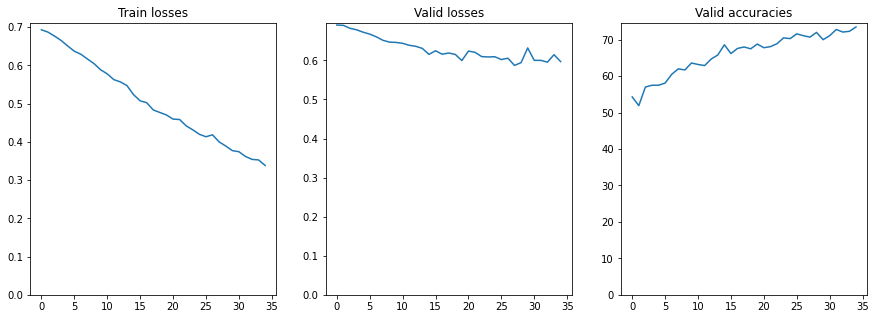

In [75]:
epochs = 35

Ntrain = Xtrain.shape[0]
Nvalid = Xvalid.shape[0]
print(Ntrain,Nvalid)
idx = np.arange(Ntrain)
batch_size = 200 # Beaucoup plus rapide que 1 ! 
nbatch = int(Ntrain/batch_size)
print(batch_size, nbatch)


train_losses,valid_losses, valid_accuracies=[],[],[]


for e in range(epochs):
    np.random.shuffle(idx)
    running_loss=0
    totaln = 0
    for bi in range(nbatch): 
        ids = idx[bi*batch_size:(bi+1)*batch_size]
        images = Xtrain[ids]
        labels = Ytrain[ids]
        totaln += labels.shape[0] 
        optimizer.zero_grad()
        logprobs=classif(images)
        loss=loss_fn(logprobs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    # training is over for one epoch
    # now compute interesting quantities
    accuracy=0
    valid_loss = 0        
    with th.no_grad(): # On est plus entrain d'apprendre, plus de gradient
        classif.eval()
        images = Xvalid
        labels = Yvalid
        logprobs=classif(images)
        valid_loss=loss_fn(logprobs,labels)
        top_p,top_class=logprobs.topk(1)
        accuracy=(top_class.T == labels).sum().float()
    classif.train()
    train_losses.append(running_loss/nbatch)
    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy.item()*100.0/Nvalid)
    '''
    print("Epoch: {}\t".format(e+1),
              "train Loss: {:.5f}.. ".format(train_losses[-1]),
              "valid Loss: {:.5f}.. ".format(valid_losses[-1]),
              "valid Accuracy: {:.3f}".format(valid_accuracies[-1])) 
    '''
print("---------- Best : {:.3f}".format(max(valid_accuracies)), " at epoch " 
      , np.fromiter(valid_accuracies, dtype=np.float).argmax(), " / ",epochs )

plt.figure(figsize = (15, 5))
ax= plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Train losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 3, 2)
plt.plot(valid_losses)
plt.title('Valid losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 3, 3)
plt.plot(valid_accuracies)
plt.title('Valid accuracies')
ax.set_ylim(bottom=0)
    